# Python Multithreading vs Multiprocessing vs AsyncIO

Python offers many different mechanisms to write concurrent code, but which is best?

To compare, we take a toy web crawler, make it concurrent by applying multithreading, multi-processing and asyncio coroutines, and compare performance.

Our baseline is the following non-concurrent, recursive implementation:


```python
def crawl(root: str) -> None:
    seen: set[str] = set()
    with requests.Session() as session:
        def crawl(url: str) -> None:
            print(f'processing {url}')
            html = session.get(url).content
            soup = BeautifulSoup(html)
            paths = {urljoin(url, a.get('href')) for a in soup.find_all('a')}
            for u in filter(lambda p: p.startswith(root) and p.endswith('/'), paths - seen):
                seen.add(u)
                crawl(u)

        crawl(root)
```

<Axes: title={'center': 'Python web crawler concurrency benchmark'}, xlabel='concurrency', ylabel='pages/sec'>

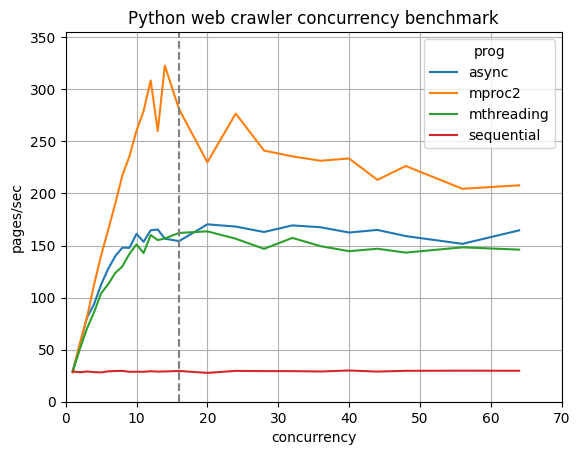

In [1]:
import pandas

df = pandas.read_csv('results.csv')
df = df.sort_values(by=['prog'])
df['speed'] = df['urls'] / df['time']
df = df.sort_values(by=['prog', 'concurrency'])

df = df.groupby(['concurrency', 'prog'])[['speed']].max()
df = df.reset_index()
max_x = int(df['concurrency'].max() * 1.1)
max_y = int(df['speed'].max() * 1.1)
df = df.set_index('concurrency')
df = df.pivot_table('speed', ['concurrency'], 'prog')

ax = df.plot(grid=True, xlim=(0, max_x), ylim=(0, max_y), title='Python web crawler concurrency benchmark', ylabel='pages/sec')
# A dotted line at 16, the number of logical CPU cores during the benchmark:
ax.axvline(16, color="grey", linestyle="--")
ax

In [2]:
display(df)

prog,async,mproc2,mthreading,sequential
concurrency,,,,
1,29.916963,28.088622,28.814783,29.004654
2,54.442719,55.885035,50.452296,28.310812
3,80.536123,80.751828,70.148369,29.017400
4,93.617960,112.134767,85.817476,28.465091
5,112.380506,140.330411,104.072480,28.138970
6,127.603408,165.087743,112.835340,29.197203
7,139.799875,190.238040,123.720890,29.487646
8,147.942715,217.398140,129.957238,29.636220
9,147.800282,235.704656,142.068534,28.746118
